# **Introducción al Quantum Machine Learning 4**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes

### Autor: **Sebastián González Juárez**

Académicos:
* Dr. Boris Escalante Ramírez
* Naomi Itzel Reyes Granados

Temas Selectos de Ingenieria III - **Introducción a la computación cuántica**.

Este ipynb agrega la posibilidad de utilizarlo con Google Colab sin necesidad de instalar nada a sus computadoras.

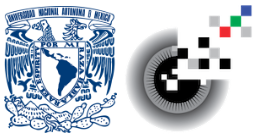

# **0) Fundamento teórico y matemático del VQE aplicado a la molécula de H₂.**

## A.  Variational Quantum Eigensolver (VQE)

Es un algoritmo híbrido (cuántico-clásico) que busca estimar el estado fundamental de un sistema cuántico, resolviendo de forma **aproximada** la ecuación de Schrödinger:
$$H|\psi\rangle = E|\psi\rangle$$

donde 𝐻 es el Hamiltoniano del sistema y 𝐸 la energía correspondiente.

El **principio variacional** clásico dice que la naturaleza escoge la trayectoria que hace estacionaria una cantidad.

Aplicando su "versión" cuántica, dice algo análogo, pero ahora aplicado a funciones de onda en lugar de trayectorias.

I.e.

en lugar de buscar la trayectoria que hace mínima la acción,
buscamos la función de onda que minimiza la energía esperada.

Sea 𝐻  el operador Hamiltoniano (energía total) de un sistema cuántico.
Para cualquier estado normalizado ∣ψ⟩:
$$E(\psi) = \langle\psi|H|\psi\rangle$$
es la energía esperada al medir el sistema en ese estado.

El principio variacional cuántico establece que:
$$E(\psi) \geq E_0$$

donde $E_0$ es la energía del estado fundamental (el valor propio más bajo de
𝐻).

Así, si logramos construir un conjunto de estados ∣ψ(θ)⟩ dependientes de parámetros θ, podemos aproximar $E_0$ minimizando la energía esperada:
$$E(\theta) = \langle\psi(\theta)|H|\psi(\theta)\rangle$$

---

## B. Representación cuántica del Hamiltoniano de H₂

Para una molécula como H₂, queremos describir la energía electrónica, es decir, cómo se mueven los electrones en el campo de los núcleos (que se mantienen fijos según la aproximación de Born-Oppenheimer).

El Hamiltoniano electrónico (en primera cuantización) es:

$$
H = \sum_i \left( -\frac{1}{2} \nabla_i^2 - \sum_A \frac{Z_A}{r_{iA}} \right) + \sum_{i<j} \frac{1}{r_{ij}}
$$

donde:

- **El primer término** es la energía cinética de los electrones
- **El segundo término** es la atracción electrón-núcleo  
- **El último término** es la repulsión electrón-electrón

### Segunda cuantización
La **segunda cuantización** reescribe el problema de muchos electrones en términos de operadores que crean y destruyen electrones en ciertos orbitales.

El Hamiltoniano se expresa como:

$$
H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s
$$

Significado de cada término:

- **$a_p^\dagger$**: operador que crea un electrón en el orbital $p$
- **$a_q$**: operador que aniquila un electrón del orbital $q$
- **$h_{pq}$**: integra la energía de un electrón, incluye cinética + atracción al núcleo:

$$
h_{pq} = \int \phi_p^*(r) \left( -\frac{1}{2} \nabla^2 - \sum_A \frac{Z_A}{r_A} \right) \phi_q(r)  dr
$$

- **$h_{pqrs}$**: integra la repulsión entre dos electrones:

$$
h_{pqrs} = \iint \phi_p^*(r_1) \phi_q^*(r_2) \frac{1}{r_{12}} \phi_r(r_2) \phi_s(r_1)  dr_1 dr_2
$$


Base Computacional

La base **STO-3G** (Slater-type orbital con 3 gaussianas) es una base mínima, muy usada para H₂ en cálculos simples de química cuántica computacional.

### Sistema de 4 Modos Fermiónicos para H₂

H₂ tiene 2 electrones y 2 orbitales espaciales (uno para cada átomo).  
Pero como cada orbital puede tener dos espines (↑, ↓), tenemos en total 4 orbitales de espín (*spin-orbitals*).

Descripción del Sistema

Por tanto, el sistema se describe con **4 modos fermiónicos** → necesitamos 4 operadores de creación/aniquilación:

$$
a_0, a_1, a_2, a_3
$$

Cada modo puede estar **ocupado (1)** o **vacío (0)**, así que el espacio total tiene:

$$
2^4 = 16 \text{ estados posibles}
$$

Sin embargo, como H₂ solo tiene **2 electrones**, trabajamos en el **subespacio con dos ocupaciones**, lo que reduce la dimensión del problema.

### Mapeo de Jordan–Wigner

Para poder simular el Hamiltoniano en una computadora cuántica, debemos expresar los operadores fermiónicos $a_p^\dagger, a_q$ en términos de operadores de Pauli (X, Y, Z) sobre qubits.

El mapeo de Jordan–Wigner hace exactamente eso:

$$
a_p^\dagger = \frac{1}{2} (X_p - iY_p) \bigotimes_{j<p} Z_j,
\quad
a_p = \frac{1}{2} (X_p + iY_p) \bigotimes_{j<p} Z_j
$$

Propiedades Clave

- Las $Z_j$ aseguran el signo antisimétrico (debido a la anticomutación de los fermiones)
- Cada orbital se mapea a un qubit
- Entonces, si hay 4 orbitales, inicialmente se necesitarían 4 qubits

Caso Especial de H₂

Pero en el caso de H₂, por simetría y restricciones de espín, el problema se puede reducir a solo **2 qubits** (el llamado *reduced qubit Hamiltonian*).

### Hamiltoniano Final en Términos de Pauli

Después de aplicar el mapeo y simplificar (usando las simetrías del sistema), el Hamiltoniano toma una forma de combinación lineal de productos de matrices de Pauli:

$$
H = c_0 I + c_1 Z_0 + c_2 Z_1 + c_3 Z_0 Z_1 + c_4 X_0 X_1 + c_5 Y_0 Y_1
$$

Componentes del Hamiltoniano

donde:

- **$I$**, **$X_i$**, **$Y_i$**, **$Z_i$** son las matrices de Pauli (o el operador identidad)
- **$c_i$** son coeficientes reales obtenidos de los integrales $h_{pq}$, $h_{pqrs}$ (dependen de la distancia internuclear)

Implementación Cuántica

Esto es el Hamiltoniano efectivo en espacio de qubits que puede implementarse en un computador cuántico para obtener la energía mínima de H₂ mediante algoritmos como VQE (Variational Quantum Eigensolver).

---

## C. Circuito Variacional (Ansatz)

El estado cuántico aproximado se genera mediante un circuito parametrizado:

$$
|\psi(\theta)\rangle = U(\theta) |00\rangle,
$$

donde $U(\theta)$ está compuesto por:

- **Rotaciones locales** ($R_x$, $H$)
- **Compuertas de entrelazamiento** ($CZ$)
- Y puede repetirse en capas (`reps`)


Recordemos que en esta interpretación, los 2 qubits codifican las posibles ocupaciones electrónicas de los orbitales de espín de H₂ (↑ y ↓, enlazante y antienlazante).

___

# **1) Instalación**


In [3]:
!pip -q install qiskit qiskit-aer qiskit-algorithms pylatexenc

import sys, numpy as np, matplotlib.pyplot as plt
import qiskit, qiskit_aer, qiskit_algorithms

print("Python  :", sys.version)
print("Qiskit  :", qiskit.__version__)
print("Aer     :", qiskit_aer.__version__)
print("Algorithms:", qiskit_algorithms.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
Python  : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Qiskit  : 2.2.3
Aer     : 0.17.2
Algorithms: 0.4.0


# **2) Imports y utilidades**

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import Estimator as AerEstimator

from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

from qiskit_algorithms.optimizers import COBYLA, SLSQP

# **3) Hamiltoniano H2 (JW reducido a 2 qubits)**

Recordemos lo que queremos construir:

$$H = c0*II + c1*ZI + c2*IZ + c3*ZZ + c4*XX + c5*YY$$




Primero vamos a definir los coeficientes (constantes reales) de cada término de Pauli:

In [5]:
c0 = -1.052373245772859   # término identidad (offset energético global)
c1 =  0.39793742484318045 # Z⊗I  (Z en qubit 0, I en qubit 1)
c2 = -0.39793742484318045 # I⊗Z  (I en qubit 0, Z en qubit 1)
c3 = -0.01128010425623538 # Z⊗Z  (acoplamiento/ correlación en la base Z)
c4 =  0.18093119978423156 # X⊗X  (término de intercambio en la base X)
c5 =  0.18093119978423156 # Y⊗Y  (término de intercambio en la base Y)

Empaquetamos los coeficientes:

In [6]:
coeffs = [c0, c1, c2, c3, c4, c5]

Ahora hay que armar una lista con las compuertas de Pauli que buscamos aplicar:
- "II"   → I⊗I
- "ZI"   → Z⊗I
- "IZ"   → I⊗Z
- "ZZ"   → Z⊗Z
- "XX"   → X⊗X
- "YY"   → Y⊗Y

In [7]:
paulis = ["II", "ZI", "IZ", "ZZ", "XX", "YY"]

Hay que armar el operador cuántico esparso (SparsePauliOp) a partir de (operador, coeficiente).

In [8]:
H2 = SparsePauliOp.from_list(list(zip(paulis, coeffs)))

print(H2)                                                                 # Mostramos la descomposición del Hamiltoniano para verificar que quedó bien:
print("N° de qubits:", H2.num_qubits)                                     # Confirmamos que el operador actúa sobre 2 qubits (dimensión 4 del espacio de Hilbert).

SparsePauliOp(['II', 'ZI', 'IZ', 'ZZ', 'XX', 'YY'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j,  0.1809312 +0.j])
N° de qubits: 2


# **4) Ansatz variacional**

Tendremos 6 parámetros, porque, usamos la configuración de TwoLocal que crea 3 capas de rotaciones paramétricas y en cada capa haremos que aplique un RX(θ) a cada qubit:

Con reps=2, el patrón es:
    
    [Rot] – [Ent] – [Rot] – [Ent] – [Rot]

En cada capa de rotación, tendremos rotation_blocks=["h","rx"] pone primero H (sin parámetros) y luego RX(θ) (1 parámetro) por qubit y tenemos 2.

In [9]:
ansatz = TwoLocal(
    num_qubits=2,                # núm. de qubits
    rotation_blocks=["h", "rx"], # bloque de rotaciones locales en cada capa: primero H (fija), luego Rx(θ) (parametrizada)
    entanglement_blocks="cz",    # bloque de entrelazamiento: compuerta CZ entre qubits
    entanglement="full",         # “full”: conecta todos con todos (en 2 qubits es CZ(0,1))
    reps=2,                      # repeticiones del patrón (a más reps, más parámetros y profundidad)
    parameter_prefix="y",        # prefijo para nombrar los parámetros (y0, y1, ...)
)

# Núm. total de parámetros:
n_params = len(ansatz.parameters)
print("Parámetros del ansatz:", n_params)

Parámetros del ansatz: 6


/tmp/ipython-input-1915559052.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


# **5) Estimator (Aer V1) y función de energía <H>**

Vamos a calcular E(θ) = ⟨ψ(θ)| H2 |ψ(θ)⟩.

    - Enviamos:
        circuits=[ansatz]         → el circuito U(θ) que prepara |ψ(θ)⟩
        observables=[H2]          → el Hamiltoniano H2 (SparsePauliOp)
        parameter_values=[theta]  → valores de los parámetros para este circuito
    - El Estimator evalúa numéricamente el valor esperado de H2 en el estado preparado por ansatz(θ).
    """

Primero crearemos el simulador:

In [10]:
est = AerEstimator()  # Estimator local (qiskit-aer)

In [11]:

def energy(theta: np.ndarray) -> float:
    job = est.run(
        circuits=[ansatz],             # lista con 1 circuito
        observables=[H2],              # lista con 1 observable (el Hamiltoniano)
        parameter_values=[theta],      # lista con 1 vector de parámetros
    )
    # job.result().values es un array con los ⟨O⟩ por cada par (circuito, observable), extraemos el valor real resultante:
    e = float(np.real(job.result().values[0]))
    return e

Hacemos una prueba rápida cuando los ángulos son 0, la cuál también nos sirve como punto de referencia.

Pues el vector |00⟩ al inicio representa un estado base (por ejemplo, ambos electrones ocupando el orbital más bajo)

In [12]:
print("Energía @ θ=0:", energy(np.zeros(n_params)))

Energía @ θ=0: -1.0728412625181374


# **6) Optimización (COBYLA / SLSQP) + trazas**

Escojamos nuestro optimizador:
- COBYLA: sin gradiente.
- SLSQP : usa gradiente numérico (SciPy).

In [13]:
OPT = "COBYLA"

Vamos a llevar un historial para la gráfica más adelante:

In [14]:
trace = {"iter": [], "energy": []}

La función va a devolver E(θ) para que el optimizador la minimice y, de paso, guarda en trace la energía y el número de evaluación de esa llamada.

In [15]:
def objective_with_trace(theta):
    e = energy(theta)
    trace["iter"].append(len(trace["iter"]))
    trace["energy"].append(e)
    return e

Partamos de nuestro punto inicial con todos los ángulos del ansatz en 0 (vector de longitud n_params):

In [16]:
theta0 = np.zeros(n_params, dtype=float)

En base a la selección y configuración del optimizador:

In [17]:
if OPT.upper() == "COBYLA":
    opt = COBYLA(maxiter=200, tol=1e-6)
elif OPT.upper() == "SLSQP":
    opt = SLSQP(maxiter=200, ftol=1e-9)
else:
    raise ValueError("OPT debe ser 'COBYLA' o 'SLSQP'.")

Utilizamos minimize con nuestro optimizador, con x0=theta0 como el vector inicial de parámetros.

In [18]:
res = opt.minimize(fun=objective_with_trace, x0=theta0)

La energía mínima encontrada evaluando en el óptimo res.x.

In [19]:
E_min = energy(res.x)

Mostramos lo que hemos hecho:

In [20]:
print(f"[{OPT}] E_min = {E_min:.8f} Hartree")                  # energía mínima estimada (estado fundamental)
print("θ* =", np.array2string(res.x, precision=6))             # parámetros óptimos del ansatz

[COBYLA] E_min = -1.89954820 Hartree
θ* = [-0.393247  1.508751  1.704672 -0.491229 -0.287848  1.360556]


# **7) Gráfica de convergencia**

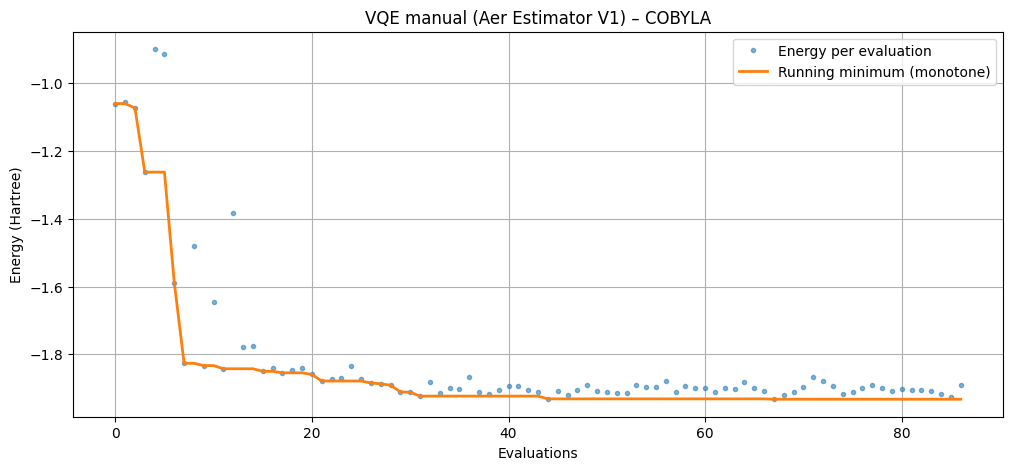

In [21]:
energies = np.array(trace["energy"])
cum_min = np.minimum.accumulate(energies)

plt.figure(figsize=(12,5))
plt.plot(energies, ".", alpha=0.55, label="Energy per evaluation")
plt.plot(cum_min, "-", lw=2.0, label="Running minimum (monotone)")
plt.xlabel("Evaluations"); plt.ylabel("Energy (Hartree)")
plt.title(f"VQE manual (Aer Estimator V1) – {OPT}")
plt.grid(True); plt.legend(); plt.show()


# **8) Comparación con referencia exacta (diagonalización)**

Resolvemos por diagonalización.

In [23]:
H_mat = H2.to_matrix(sparse=False)     # matriz densa 4x4
w, _ = np.linalg.eigh(H_mat)           # autovalores ordenados
E_exact = float(np.min(w))             # estado fundamental

print(f"E_exact (diagonalización) = {E_exact:.8f} Hartree")
print(f"|Δ| = |E_min - E_exact| = {abs(E_min - E_exact):.3e} Hartree")


E_exact (diagonalización) = -1.91537066 Hartree
|Δ| = |E_min - E_exact| = 1.582e-02 Hartree


Hicimos muy buena aproximación.

# **Otros notebooks:**
https://github.com/Bayan0708/Quantum-Machine-Learning/tree/main/03_Introduction_to_QML_Class